# Jitter box plots

For each scenario get all successful calls and divide data on clientIDs i.e. db.calls.find({"scenario_type": "1","client_username": "d1_Normal", "state": "call_ended"})

For all the client ids, find all the reports data where it's either Inbound jitter. Add this data field to the data frame of the given scenario and client type (Alice or Bob).

In [1]:
import sys
from dotenv import load_dotenv
from datetime import datetime, timedelta
import pandas as pd
import os
import json
import logging
import matplotlib.pyplot as plt
from helperFunctions import getScenarioLabels, scenarios
import numpy as np

logging.basicConfig(
  format=f'%(asctime)s %(levelname)-8s %(message)s ',
  level=logging.INFO,
  datefmt='%Y-%m-%d %H:%M:%S',
  handlers=[
  logging.StreamHandler(sys.stdout)
  ])

callAndOutcomeFile = "output_folder/UniqueCallsAndOutcomes.csv"
outputFolder = "output_folder/"


if not os.path.exists(outputFolder):

   # Create a new directory because it does not exist
   os.makedirs(outputFolder)
   logging.info(f"The directory \"{outputFolder}\" is created!")

In [2]:
plotDf = pd.DataFrame(columns=["scenario", "client", "mediaType", "jitter"])

callsDf = pd.read_csv(callAndOutcomeFile)

logging.info(f"shape of calls: {callsDf.shape}")

# filter for calls with state success
successCallsDf = callsDf.loc[callsDf["logging_type"] == "COMMAND_SESSION_SUCCESS"]

logging.info(f"shape of success full calls: {successCallsDf.shape}")



for scenario in scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  logging.info(f"Starting on scenario {s}, alice: {a}, bob: {b}")

  # filter for calls with scenario_type s
  scenarioCallsDf = successCallsDf.loc[successCallsDf["scenario_type"] == s]

  # get list of room_ids in scenarioCallsDf
  roomIds = scenarioCallsDf["room_id"].unique()

  reportForClientA = pd.read_csv(f"output_folder/rawReport/{a}.csv")
  reportForClientVideoA = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") ]
  dataVideoA = pd.DataFrame(columns=["scenario", "client", "mediaType", "jitter"]).assign(jitter=reportForClientVideoA["jitter"])
  dataVideoA = dataVideoA.assign(scenario=s, client=a, mediaType="video")

  reportForClientAudioA = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "audio") ]
  dataAudioA = pd.DataFrame(columns=["scenario", "client", "mediaType", "jitter"]).assign(jitter=reportForClientAudioA["jitter"])
  dataAudioA = dataAudioA.assign(scenario=s, client=a, mediaType="audio")

  reportForClientB = pd.read_csv(f"output_folder/rawReport/{b}.csv")
  reportForClientVideoB = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") ]
  dataVideoB = pd.DataFrame(columns=["scenario", "client", "mediaType", "jitter"]).assign(jitter=reportForClientVideoB["jitter"])
  dataVideoB = dataVideoB.assign(scenario=s, client=b, mediaType="video")

  reportForClientAudioB = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "audio") ]
  dataAudioB = pd.DataFrame(columns=["scenario", "client", "mediaType", "jitter"]).assign(jitter=reportForClientAudioB["jitter"])
  dataAudioB = dataAudioB.assign(scenario=s, client=b, mediaType="audio")

  plotDf = pd.concat([plotDf, dataVideoA, dataAudioA, dataVideoB, dataAudioB], ignore_index=True)

logging.info(f"jitterPlotDf shape: {plotDf.shape}")

# save plotDf to csv
plotDf.to_csv(f"{outputFolder}/jitterPlotDf.csv",index=False, header=True, encoding='utf-8', mode='w')


2023-01-30 13:52:45 INFO     shape of calls: (23513, 14) 
2023-01-30 13:52:45 INFO     shape of success full calls: (19064, 14) 
2023-01-30 13:52:45 INFO     Starting on scenario 1, alice: c1-Normal, bob: d1-Normal 
2023-01-30 13:52:51 INFO     Starting on scenario 2, alice: c2-TorNormal, bob: d2-TorNormal 
2023-01-30 13:52:55 INFO     Starting on scenario 3, alice: c3-TorEurope, bob: d3-TorEurope 
2023-01-30 13:53:00 INFO     Starting on scenario 4, alice: c4-TorScandinavia, bob: d4-TorScandinavia 
2023-01-30 13:53:03 INFO     Starting on scenario 5, alice: c6-Lokinet, bob: d6-Lokinet 
2023-01-30 13:53:06 INFO     Starting on scenario 6, alice: c1-Normal, bob: d2-TorNormal 
2023-01-30 13:53:11 INFO     Starting on scenario 7, alice: c2-TorNormal, bob: d1-Normal 
2023-01-30 13:53:17 INFO     Starting on scenario 8, alice: c1-Normal, bob: d3-TorEurope 
2023-01-30 13:53:22 INFO     Starting on scenario 9, alice: c3-TorEurope, bob: d1-Normal 
2023-01-30 13:53:27 INFO     Starting on scena

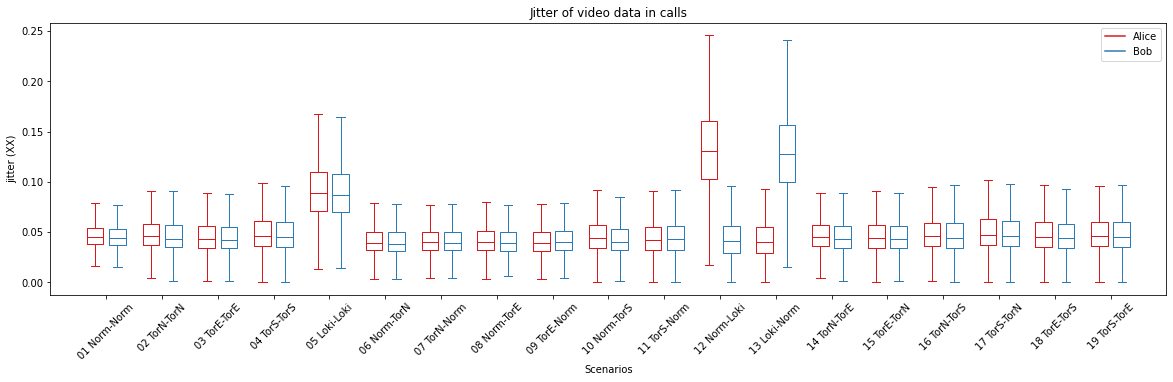

In [5]:
dataA = []
dataB = []
for scenario in scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "video") & (plotDf["client"] == scenario["alice"])]["jitter"].values)
  dataB.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "video") & (plotDf["client"] == scenario["bob"])]["jitter"].values)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.legend()
plt.title("Jitter of video data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

#plt.ylim(0, 2500)
plt.ylabel('jitter (s)')


plt.savefig("output_folder/BoxPlotJitterVideo.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotJitterVideo.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

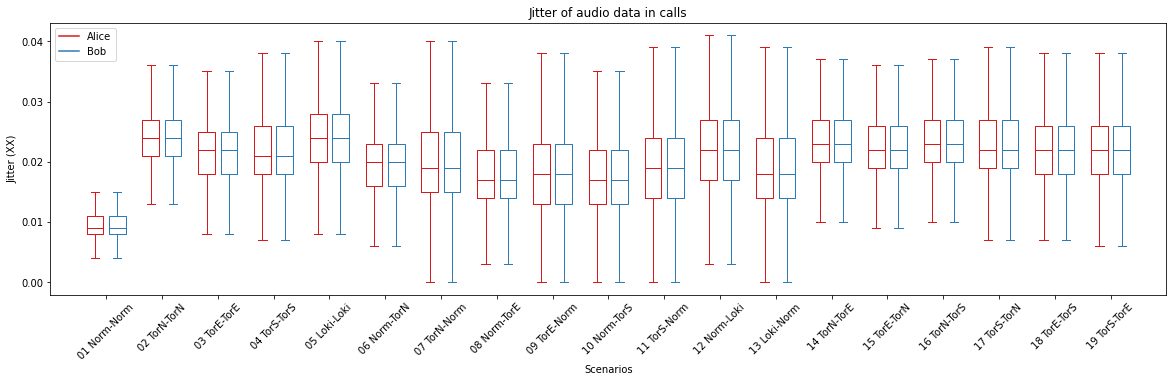

In [6]:
dataA = []
dataB = []
for scenario in scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == scenario["alice"])]["jitter"].values)
  dataB.append(plotDf.loc[(plotDf["scenario"] == scenario["scenario"]) & (plotDf["mediaType"] == "audio") & (plotDf["client"] == scenario["bob"])]["jitter"].values)

  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.legend()
plt.title("Jitter of audio data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = getScenarioLabels(plotDf["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

plt.ylabel('Jitter (XX)')


plt.savefig("output_folder/BoxPlotJitterAudio.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotJitterAudio.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()